In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np

# modules from sklearn used in regression analysis
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import mean_squared_error

# module for Q-Q plot
from scipy import stats

# ignore warnings from seaborn and sklearn
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

pd.options.display.max_rows = 100

In [2]:
df_train = pd.read_csv("https://raw.githubusercontent.com/jpconher/Kaggle/main/House%20Prices%20-%20Advanced%20Regression%20Techniques/data/train.csv")
df_test = pd.read_csv("https://raw.githubusercontent.com/jpconher/Kaggle/main/House%20Prices%20-%20Advanced%20Regression%20Techniques/data/test.csv")

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

## Initial data exploration

In [4]:
df_train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


1460 observations and 81 variables (including $Id$ and the dependent variable $SalePrice$) in the traning data set.

In [5]:
df_train.shape

(1460, 81)

Both non-numeric variables (object type) and numeric variables (int64 and float64).

In [6]:
df_train.dtypes.value_counts()

object     43
int64      35
float64     3
dtype: int64

Average sale price 180,921\$. Maximum and minimum sale prices 755,000\$ and 34,900\$, respectively.

In [7]:
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

The distribution is positively skewed and leptokurtic. Its shape resembles a lognormal distribution.

<Axes: xlabel='SalePrice', ylabel='Count'>

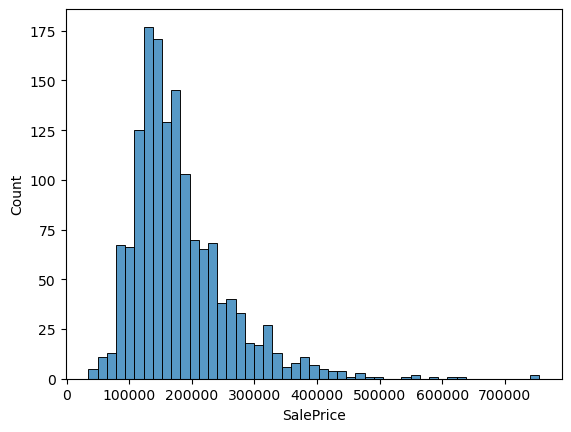

In [8]:
sns.histplot(df_train['SalePrice'])

In [9]:
print("Kurtosis:", df_train['SalePrice'].kurtosis(), "; Skewness:", df_train['SalePrice'].skew())

Kurtosis: 6.536281860064529 ; Skewness: 1.8828757597682129


<Axes: xlabel='GrLivArea', ylabel='SalePrice'>

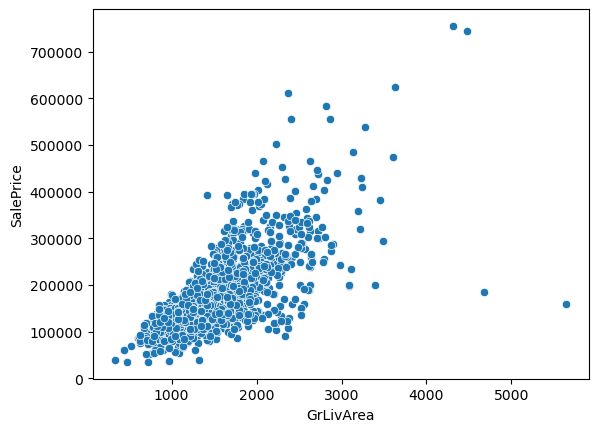

In [10]:
sns.scatterplot(data = df_train, x = 'GrLivArea', y = 'SalePrice')

<Axes: xlabel='LotArea', ylabel='SalePrice'>

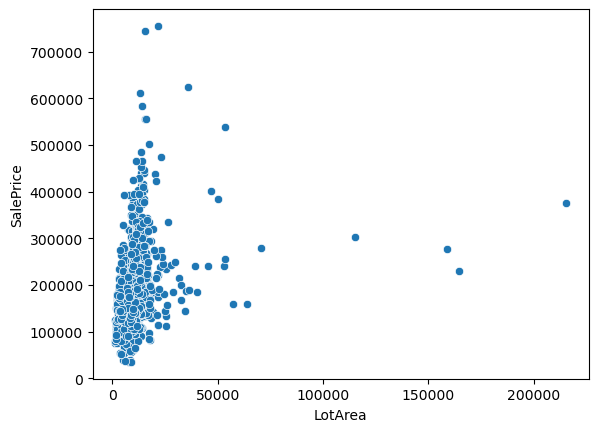

In [11]:
sns.scatterplot(data = df_train, x = 'LotArea', y = 'SalePrice')

In [12]:
df_train = df_train[(df_train['GrLivArea'] < 4000) & (df_train['LotArea'] < 100000)]
df_train.shape

(1452, 81)

In [13]:
df = df_train.append(df_test)
df.shape

(2911, 81)

In [14]:
missing_data = df.isna().sum().sort_values(ascending = False)
missing_data.head(20)

PoolQC          2903
MiscFeature     2808
Alley           2713
Fence           2341
SalePrice       1459
FireplaceQu     1420
LotFrontage      483
GarageFinish     159
GarageQual       159
GarageCond       159
GarageYrBlt      159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
dtype: int64

In [15]:
# missing indicates lack of amenity
df['PoolQC'] = df['PoolQC'].fillna('No_pool')
df['MiscFeature'] = df['MiscFeature'].fillna('No_misc')
df['Alley'] = df['Alley'].fillna('No_alley')
df['Fence'] = df['Fence'].fillna('No_fence')
df['FireplaceQu'] = df['FireplaceQu'].fillna('No_fireplace')
df['GarageFinish'] = df['GarageFinish'].fillna('No_garage')
df['GarageQual'] = df['GarageQual'].fillna('No_garage')
df['GarageCond'] = df['GarageCond'].fillna('No_garage')
df['GarageType'] = df['GarageType'].fillna('No_garage')
df['BsmtExposure'] = df['BsmtExposure'].fillna('No_basement')
df['BsmtCond'] = df['BsmtCond'].fillna('No_basement')
df['BsmtQual'] = df['BsmtQual'].fillna('No_basement')
df['BsmtFinType2'] = df['BsmtFinType2'].fillna('No_basement')
df['BsmtFinType1'] = df['BsmtFinType1'].fillna('No_basement')
df['BsmtExposure'] = df['BsmtExposure'].fillna('No_basement')
df['MasVnrType'] = df['MasVnrType'].fillna('No_masvnr')

# missing does not indicate lack of amenity
df['MSZoning'] = df['MSZoning'].fillna(df['MSZoning'].mode()[0])
df['Utilities'] = df['Utilities'].fillna(df['Utilities'].mode()[0])
df['Functional'] = df['Functional'].fillna(df['Functional'].mode()[0])
df['Exterior1st'] = df['Exterior1st'].fillna(df['Exterior1st'].mode()[0])
df['Exterior2nd'] = df['Exterior2nd'].fillna(df['Exterior2nd'].mode()[0])
df['SaleType'] = df['SaleType'].fillna(df['SaleType'].mode()[0])
df['KitchenQual'] = df['KitchenQual'].fillna(df['KitchenQual'].mode()[0])
df['Electrical'] = df['Electrical'].fillna(df['Electrical'].mode()[0])

In [16]:
df['LotFrontage'] = df['LotFrontage'].fillna(df['LotArea']**0.5)
df['GarageYrBlt'] = df['GarageYrBlt'].fillna(df['YearBuilt'])

# median/most frequent value imputation
df['MasVnrArea'] = df['MasVnrArea'].fillna(df['MasVnrArea'].median())
df['BsmtFullBath'] = df['BsmtFullBath'].fillna(df['BsmtFullBath'].mode()[0])
df['BsmtHalfBath'] = df['BsmtHalfBath'].fillna(df['BsmtHalfBath'].mode()[0])
df['GarageCars'] = df['GarageCars'].fillna(df['GarageCars'].mode()[0])
df['GarageArea'] = df['GarageArea'].fillna(df['GarageArea'].median())
df['TotalBsmtSF'] = df['TotalBsmtSF'].fillna(df['TotalBsmtSF'].median())
df['BsmtUnfSF'] = df['BsmtUnfSF'].fillna(df['BsmtUnfSF'].median())
df['BsmtFinSF2'] = df['BsmtFinSF2'].fillna(df['BsmtFinSF2'].median())
df['BsmtFinSF1'] = df['BsmtFinSF1'].fillna(df['BsmtFinSF1'].median())

missing_data = df.isna().sum().sort_values(ascending = False)
missing_data.head(5)

SalePrice      1459
CentralAir        0
GarageYrBlt       0
GarageType        0
FireplaceQu       0
dtype: int64

In [17]:
df = df.replace({"MSSubClass":{20:"SC20", 30:"SC30", 40:"SC40",
                               45:"SC45", 50:"SC50", 60:"SC60",
                               70:"SC70", 75:"SC75", 80:"SC80",
                               85:"SC85", 90:"SC90", 120:"SC120",
                               150:"SC150", 160:"SC160",
                               180:"SC180", 190:"SC190"},
                 "MoSold":{1:"Jan", 2:"Feb", 3:"Mar", 4:"Apr",
                           5:"May", 6:"Jun", 7:"Jul", 8:"Aug",
                           9:"Sep", 10:"Oct", 11:"Nov", 12:"Dec"}})

In [18]:
df['HeatingQC'] = df['HeatingQC'].replace('Po', 'Fa')

def season_winter(row):
  if row['MoSold'] in ['Dec', 'Jan', 'Feb']:
    return 1
  else:
    return 0

df['Winter'] = df.apply(lambda row: season_winter(row), axis = 1).astype('int8')

def winter_poor_heating_dummy(row):
  if (row['Winter'] == 1) & (row['HeatingQC'] == 'Fa'):
    return 1
  else:
    return 0

df['Winter_poor_heating'] = df.apply(lambda row: winter_poor_heating_dummy(row),
                                     axis = 1).astype('int8')

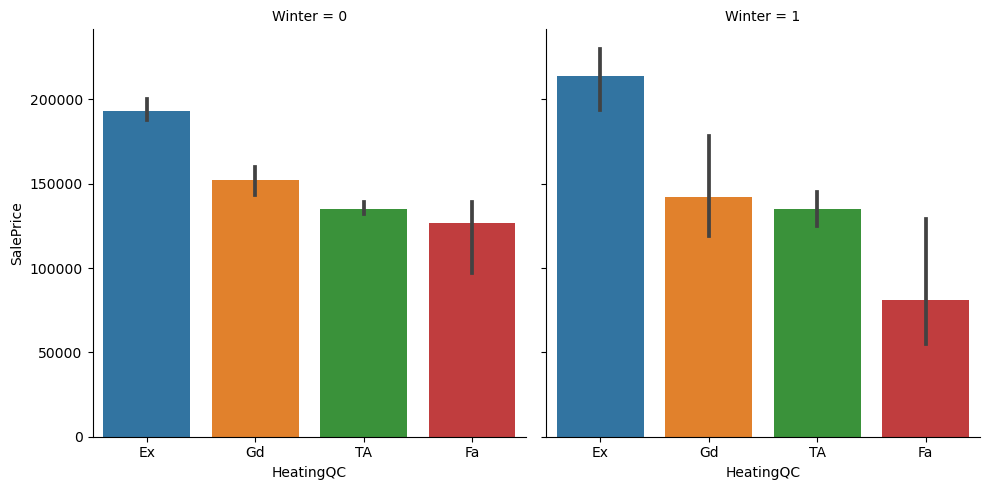

In [19]:
sns.catplot(df, x = 'HeatingQC', y = 'SalePrice', col = 'Winter', kind = 'bar', estimator = 'median')

<Axes: xlabel='OverallCond', ylabel='SalePrice'>

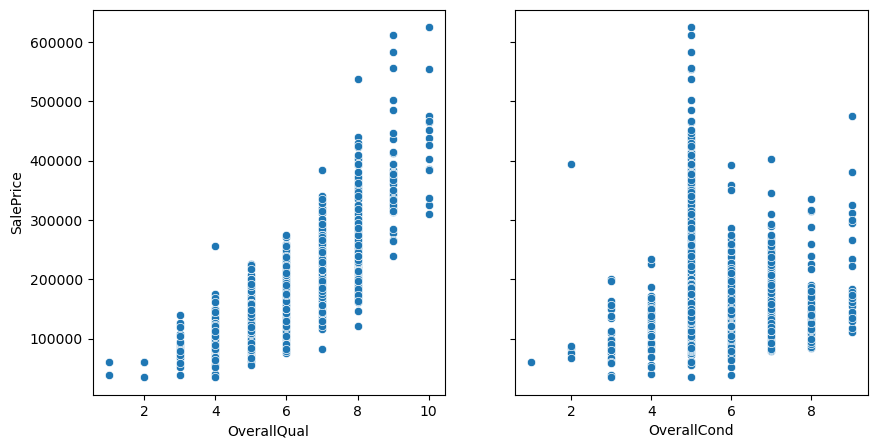

In [20]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5), sharey = True)
sns.scatterplot(df, x='OverallQual', y='SalePrice', ax = axes[0])
sns.scatterplot(df, x='OverallCond', y='SalePrice', ax = axes[1])

In [21]:
df.groupby('OverallCond')['SalePrice'].agg(['count', 'mean'])

,count,mean
OverallCond,,
1,1,61000.000000
2,5,141986.400000
3,25,101929.400000
4,57,120438.438596
5,816,202226.552696
6,250,151257.484000
7,204,157562.867647
8,72,155651.736111
9,22,216004.545455


In [22]:
def dummy_condition(row):
  if row['OverallCond'] < 5:
    return 1
  else:
    return 0

df['Poor_condition'] = df.apply(lambda row: dummy_condition(row),
                                axis = 1).astype('int8')

def dummy_extercondition(row):
  if row['ExterCond']in ['Fa', 'Po']:
    return 1
  else:
    return 0

df['Poor_exter_condition'] = df.apply(lambda row: dummy_extercondition(row),
                                axis = 1).astype('int8')

In [23]:
def numerical_encoding(row, col_name):
  if row[col_name] == 'Ex':
    return 5
  elif row[col_name] == 'Gd':
    return 4
  elif row[col_name] == 'TA':
    return 3
  elif row[col_name] == 'Fa':
    return 2
  elif row[col_name] == 'Po':
    return 1
  else:
    return 0

df['HeatingQC'] = df.apply(lambda row: numerical_encoding(row, 'HeatingQC'), axis = 1).astype('int8')
df['KitchenQual'] = df.apply(lambda row: numerical_encoding(row, 'KitchenQual'), axis = 1).astype('int8')
df['ExterQual'] = df.apply(lambda row: numerical_encoding(row, 'ExterQual'), axis = 1).astype('int8')
df['ExterCond'] = df.apply(lambda row: numerical_encoding(row, 'ExterCond'), axis = 1).astype('int8')
df['BsmtQual'] = df.apply(lambda row: numerical_encoding(row, 'BsmtQual'), axis = 1).astype('int8')
df['FireplaceQu'] = df.apply(lambda row: numerical_encoding(row, 'FireplaceQu'), axis = 1).astype('int8')

In [24]:
df['Condition'] = (df['OverallQual'] + df['OverallCond'] + df['ExterQual'] + \
                  df['ExterCond'] + df['KitchenQual'])/5

Location = pd.qcut(df.groupby('Neighborhood')['Condition'].agg('mean'), 4, labels = ['bad', 'fair', 'good', 'excellent'])
df = pd.merge(df, Location.rename('Location'), how = 'left', on = 'Neighborhood')

# drop intermediate variables
df = df.drop(['Condition'], axis = 1)

<Axes: xlabel='Foundation', ylabel='SalePrice'>

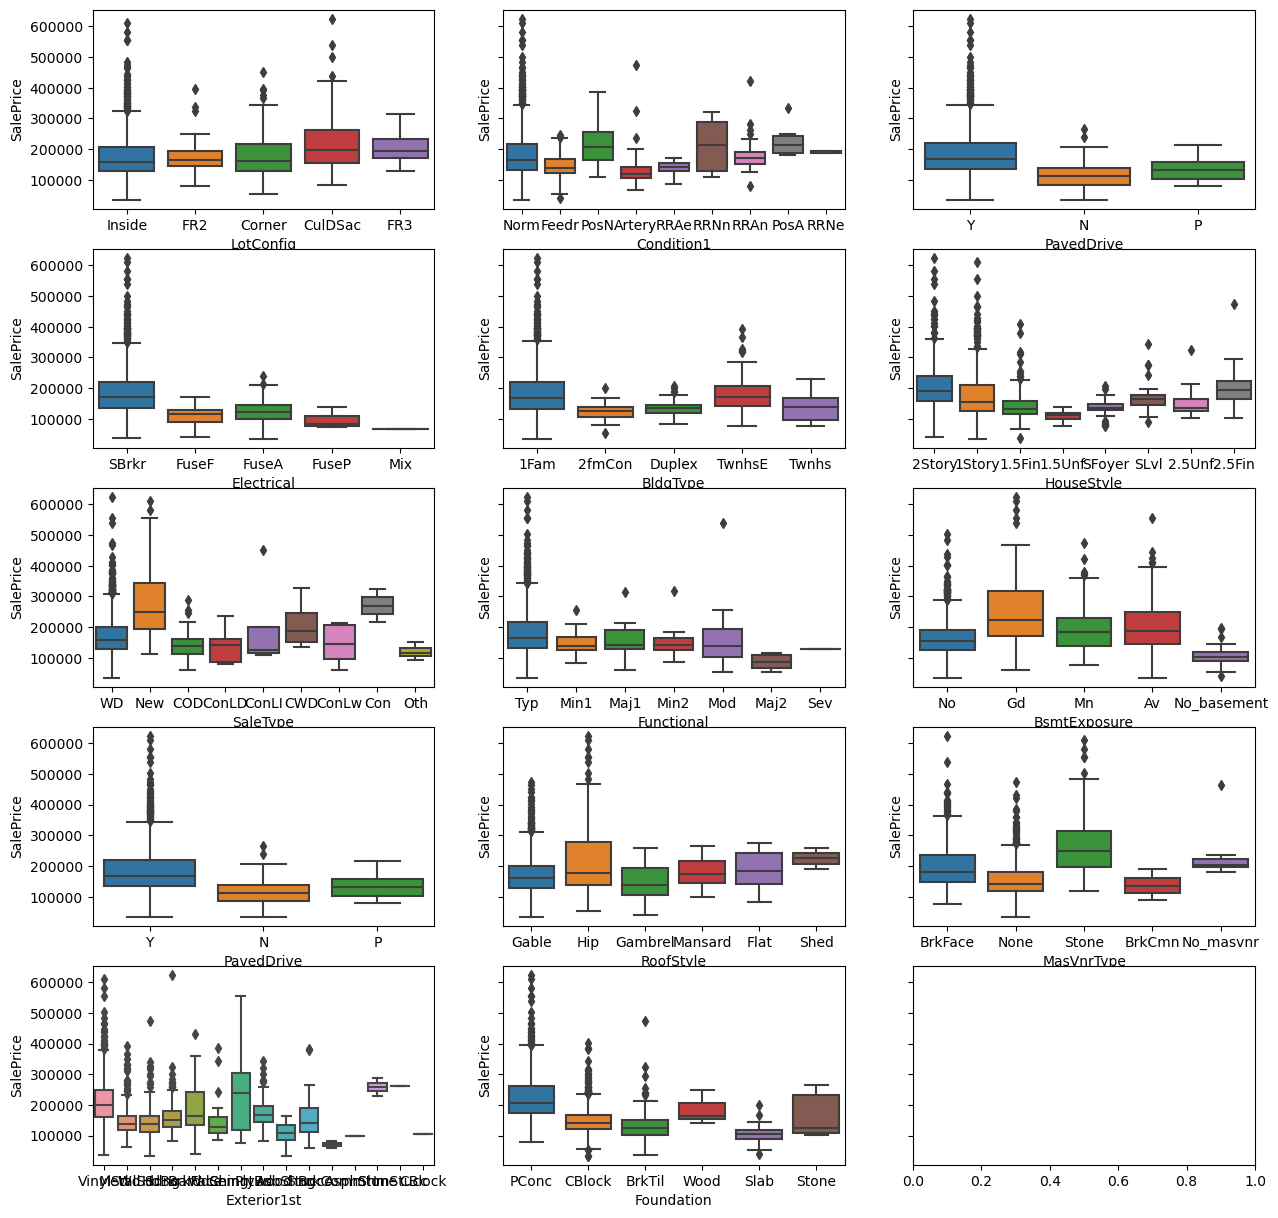

In [25]:
fig, axes = plt.subplots(5, 3, figsize = (15, 15), sharey = True)
sns.boxplot(df, y = 'SalePrice', x = 'LotConfig', ax = axes[0,0])
sns.boxplot(df, y = 'SalePrice', x = 'Condition1', ax = axes[0,1])
sns.boxplot(df, y = 'SalePrice', x = 'PavedDrive', ax = axes[0,2])
sns.boxplot(df, y = 'SalePrice', x = 'Electrical', ax = axes[1,0])
sns.boxplot(df, y = 'SalePrice', x = 'BldgType', ax = axes[1,1])
sns.boxplot(df, y = 'SalePrice', x = 'HouseStyle', ax = axes[1,2])
sns.boxplot(df, y = 'SalePrice', x = 'SaleType', ax = axes[2,0])
sns.boxplot(df, y = 'SalePrice', x = 'Functional', ax = axes[2,1])
sns.boxplot(df, y = 'SalePrice', x = 'BsmtExposure', ax = axes[2,2])
sns.boxplot(df, y = 'SalePrice', x = 'PavedDrive', ax = axes[3,0])
sns.boxplot(df, y = 'SalePrice', x = 'RoofStyle', ax = axes[3,1])
sns.boxplot(df, y = 'SalePrice', x = 'MasVnrType', ax = axes[3,2])
sns.boxplot(df, y = 'SalePrice', x = 'Exterior1st', ax = axes[4,0])
sns.boxplot(df, y = 'SalePrice', x = 'Foundation', ax = axes[4,1])

In [26]:
# create Cul_de_sac dummy
def cul_de_sac_dummy(row):
  if row['LotConfig'] == 'CulDSac':
    return 1
  else:
    return 0

df['Cul_de_sac'] = df.apply(lambda row: cul_de_sac_dummy(row), axis = 1).astype('int8')

# create Positive feature dummy
def positive_feature_dummy(row):
  if (row['Condition1'] in ['PosN', 'PosA']) or (row['Condition2'] in ['PosN', 'PosA']):
    return 1
  else:
    return 0

df['Positive_feature'] = df.apply(lambda row: positive_feature_dummy(row), axis = 1).astype('int8')

# create Adjacent_main_road dummy
def adjacent_main_road_dummy(row):
  if (row['Condition1'] in ['Artery', 'Feedr', 'RRAe']) or \
     (row['Condition2'] in ['Artery', 'Feedr', 'RRAe']):
    return 1
  else:
    return 0

df['Adjacent_main_road'] = df.apply(lambda row: adjacent_main_road_dummy(row), axis = 1).astype('int8')

# create Fuse_electrical dummy
def fuse_electrical_dummy(row):
  if (row['Electrical'] in ['FuseA', 'FuseF', 'FuseP', 'Mix']):
    return 1
  else:
    return 0

df['Fuse_electrical'] = df.apply(lambda row: fuse_electrical_dummy(row), axis = 1).astype('int8')

# create Shared_walls dummy
def shared_walls_dummy(row):
  if (row['BldgType'] in ['2FmCon', 'Duplx', 'Twnhs']):
    return 1
  else:
    return 0

df['Shared_walls'] = df.apply(lambda row: shared_walls_dummy(row), axis = 1).astype('int8')

# create Unfinish dummy
def unfinish_dummy(row):
  if (row['HouseStyle'] in ['1.5Unf', '2.5Unf']):
    return 1
  else:
    return 0

df['Unfinish'] = df.apply(lambda row: unfinish_dummy(row), axis = 1).astype('int8')

# create New dummy
def new_dummy(row):
  if (row['SaleType'] == 'New'):
    return 1
  else:
    return 0

df['New'] = df.apply(lambda row: new_dummy(row), axis = 1).astype('int8')

# create Deduction dummy
def deduction_dummy(row):
  if (row['Functional'] == 'Typ'):
    return 0
  else:
    return 1

df['Deduction'] = df.apply(lambda row: deduction_dummy(row), axis = 1).astype('int8')

# create Good_basement_exposure dummy
def basement_exposure_dummy(row):
  if (row['BsmtExposure'] == 'Gd'):
    return 1
  else:
    return 0

df['Good_bsmt_exposure'] = df.apply(lambda row: basement_exposure_dummy(row),
                                        axis = 1).astype('int8')

# create Driveway_paved dummy
def driveway_paved_dummy(row):
  if (row['PavedDrive'] == 'Y'):
    return 1
  else:
    return 0

df['Driveway_paved'] = df.apply(lambda row: driveway_paved_dummy(row),
                                        axis = 1).astype('int8')

# create Street_paved dummy
def street_dummy(row):
  if (row['Street'] == 'Pave'):
    return 1
  else:
    return 0

df['Street_paved'] = df.apply(lambda row: street_dummy(row), axis = 1).astype('int8')

# create Hip_roof dummy
def hiproof_dummy(row):
  if row['RoofStyle'] == 'Hip':
    return 1
  else:
    return 0

df['Hip_roof'] = df.apply(lambda row: hiproof_dummy(row), axis = 1).astype('int8')

# create Vinyl_ext dummy
def vinyl_dummy(row):
  if row['Exterior1st'] == 'VinylSd':
    return 1
  else:
    return 0

df['Vinyl_ext'] = df.apply(lambda row: vinyl_dummy(row), axis = 1).astype('int8')

# create Stone_masvnr dummy
def stone_dummy(row):
  if row['MasVnrType'] == 'Stone':
    return 1
  else:
    return 0

df['Stone_masvnr'] = df.apply(lambda row: stone_dummy(row), axis = 1).astype('int8')

# create Concrete_foundation dummy
def concrete_dummy(row):
  if row['Foundation'] == 'PConc':
    return 1
  else:
    return 0

df['Concrete_foundation'] = df.apply(lambda row: concrete_dummy(row), axis = 1).astype('int8')

# encode CentralAir as numerical
def air_numerical(row):
  if (row['CentralAir'] == 'Y'):
    return 1
  else:
    return 0

df['CentralAir'] = df.apply(lambda row: air_numerical(row), axis = 1).astype('int8')

In [27]:
df_train.groupby('YrSold')['SalePrice'].mean()

YrSold
2006    182549.458599
2007    181947.614198
2008    177247.500000
2009    178851.783383
2010    177393.674286
Name: SalePrice, dtype: float64

In [28]:
def one_hot_year(row):
  if row['YrSold'] >= 2008:
    return 1
  else:
    return 0

df['GFC'] = df.apply(lambda row: one_hot_year(row), axis = 1).astype('int8')

<Axes: xlabel='Age', ylabel='SalePrice'>

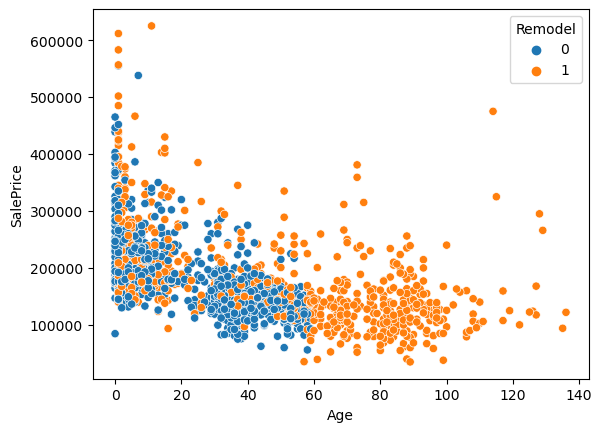

In [29]:
df['Age'] = df['YrSold'] - df['YearBuilt']

def label_remodel (row):
  if row['YearBuilt'] < row['YearRemodAdd'] :
    return 1
  else:
    return 0

df['Remodel'] = df.apply(lambda row: label_remodel(row), axis=1).astype('int8')

sns.scatterplot(df, x='Age', y='SalePrice', hue='Remodel')

<Axes: xlabel='GrLivArea', ylabel='SalePrice'>

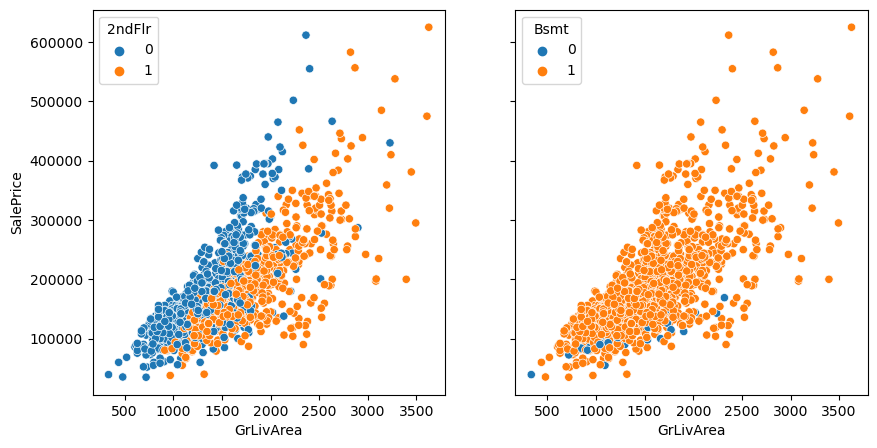

In [30]:
df['2ndFlr'] = pd.cut(df['2ndFlrSF'], bins = [-float('inf'), 0, float('inf')],
                      labels = [0, 1]).astype('int8')
df['Bsmt'] = pd.cut(df['TotalBsmtSF'], bins = [-float('inf'), 0, float('inf')],
                                  labels = [0, 1]).astype('int8')

fig, axes = plt.subplots(1, 2, figsize = (10, 5), sharey = True)
sns.scatterplot(df, x='GrLivArea', y='SalePrice', hue='2ndFlr', ax = axes[0])
sns.scatterplot(df, x='GrLivArea', y='SalePrice', hue='Bsmt', ax = axes[1])

<Axes: xlabel='Pool', ylabel='SalePrice'>

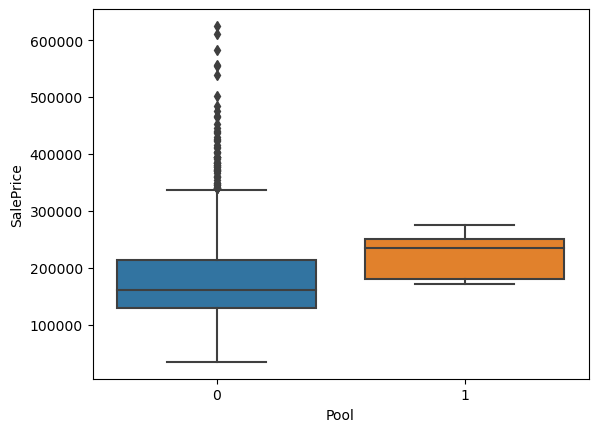

In [31]:
df['Pool'] = pd.cut(df['PoolArea'], bins = [-float('inf'), 0, float('inf')],
                                  labels = [0, 1]).astype('int8')
sns.boxplot(df, x = 'Pool', y = 'SalePrice')

In [32]:
# brings 'SalePrice' to the latest column position
columns_order = [col for col in df.columns if col != 'SalePrice'] + ['SalePrice']
df = df[columns_order]

<Axes: >

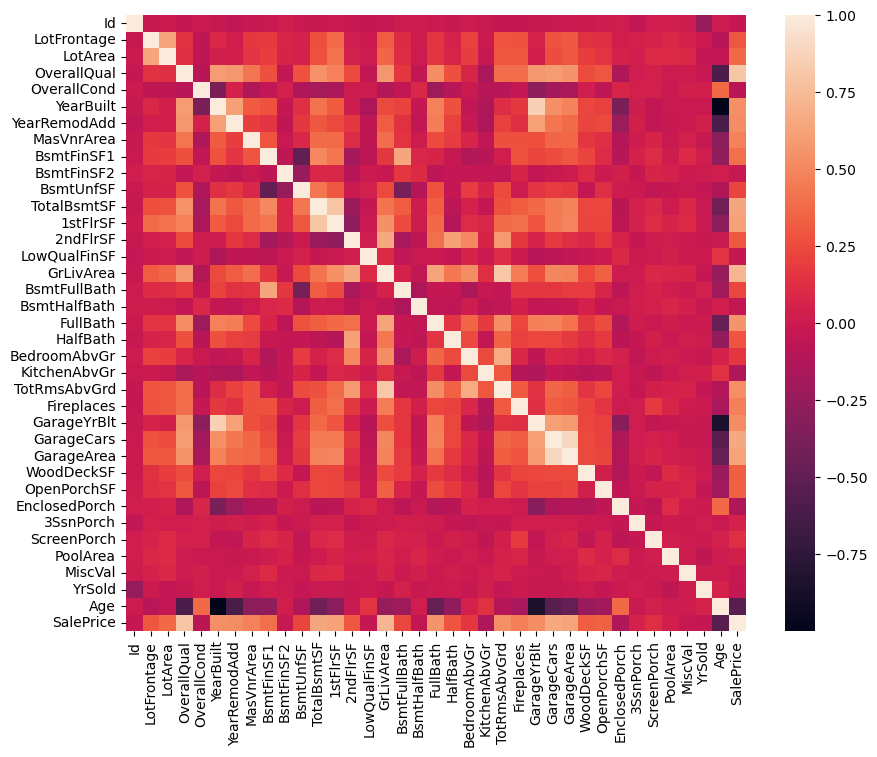

In [33]:
correlation_matrix = df.select_dtypes(exclude = 'int8').corr()

plt.subplots(figsize = (10, 8))
sns.heatmap(correlation_matrix, vmax = 1)

In [34]:
variables = ['SalePrice', 'Id', 'HeatingQC', 'OverallQual', 'KitchenQual',
             'ExterQual', 'BsmtQual', 'Age', 'GrLivArea', 'BedroomAbvGr',
             'TotalBsmtSF', 'FireplaceQu', 'TotRmsAbvGrd', 'FullBath', 'HalfBath',
             'GarageCars', 'LotArea', 'Winter_poor_heating', 'Poor_condition',
             'Poor_exter_condition', 'Location',  'Cul_de_sac',
             'Positive_feature', 'Adjacent_main_road', 'Fuse_electrical',
             'Shared_walls', 'Unfinish', 'New', 'Deduction', 'Good_bsmt_exposure',
             'Driveway_paved', 'Street_paved', 'Hip_roof', 'Vinyl_ext',
             'Stone_masvnr', 'Concrete_foundation', 'CentralAir', 'GFC', 'Remodel',
             '2ndFlr', 'Bsmt', 'Pool', 'Fireplaces', 'MSZoning', 'GarageType']

df = df[variables]

df['LotArea_2'] = df['LotArea']**2
df['Age_2'] = df['Age']**2
df['GrLivArea_2'] = df['GrLivArea']**2

<Axes: xlabel='GrLivArea', ylabel='SalePrice'>

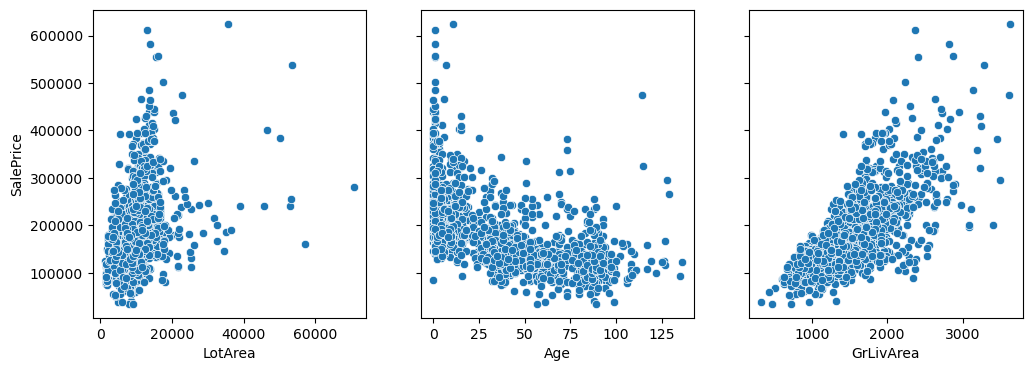

In [35]:
fig, axes = plt.subplots(1, 3, figsize = (12, 4), sharey = True)
sns.scatterplot(df, y = 'SalePrice', x = 'LotArea', ax = axes[0])
sns.scatterplot(df, y = 'SalePrice', x = 'Age', ax = axes[1])
sns.scatterplot(df, y = 'SalePrice', x = 'GrLivArea', ax = axes[2])

In [36]:
df = pd.get_dummies(df)
df.columns

Index(['SalePrice', 'Id', 'HeatingQC', 'OverallQual', 'KitchenQual',
       'ExterQual', 'BsmtQual', 'Age', 'GrLivArea', 'BedroomAbvGr',
       'TotalBsmtSF', 'FireplaceQu', 'TotRmsAbvGrd', 'FullBath', 'HalfBath',
       'GarageCars', 'LotArea', 'Winter_poor_heating', 'Poor_condition',
       'Poor_exter_condition', 'Cul_de_sac', 'Positive_feature',
       'Adjacent_main_road', 'Fuse_electrical', 'Shared_walls', 'Unfinish',
       'New', 'Deduction', 'Good_bsmt_exposure', 'Driveway_paved',
       'Street_paved', 'Hip_roof', 'Vinyl_ext', 'Stone_masvnr',
       'Concrete_foundation', 'CentralAir', 'GFC', 'Remodel', '2ndFlr', 'Bsmt',
       'Pool', 'Fireplaces', 'LotArea_2', 'Age_2', 'GrLivArea_2',
       'Location_bad', 'Location_fair', 'Location_good', 'Location_excellent',
       'MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL',
       'MSZoning_RM', 'GarageType_2Types', 'GarageType_Attchd',
       'GarageType_Basment', 'GarageType_BuiltIn', 'GarageType_CarPort',
       

In [37]:
df = df.drop(['MSZoning_RL', 'Location_bad', 'GarageType_No_garage'], axis = 1)

# interaction terms
df['Age_Remodel'] = df['Remodel']*df['Age']
df['GrLivArea_2ndFlr'] = df['GrLivArea']*df['2ndFlr']
df['GrLivArea_Bsmt'] = df['GrLivArea']*df['Bsmt']

df_train = df.iloc[0:df_train.shape[0]]
df_test = df.iloc[df_train.shape[0]:]

df_train.shape

(1452, 61)

# Regression analysis

In [38]:
X = df_train.drop(['SalePrice', 'Id'], axis = 1)
Y = np.log(df_train['SalePrice'])

train_valid_X, test_X, train_valid_Y, test_Y = train_test_split(X, Y, test_size = 0.2, random_state = 0)

In [39]:
scaler = StandardScaler()
train_valid_X = pd.DataFrame(scaler.fit_transform(train_valid_X),
                             columns = train_valid_X.columns)
test_X = pd.DataFrame(scaler.transform(test_X), columns = test_X.columns)

In [40]:
lr_lasso = Lasso()
param_grid = {
    'alpha': np.logspace(-6, -2, 100)
}

lr_lasso = GridSearchCV(lr_lasso, param_grid, scoring='neg_root_mean_squared_error', cv=5)
lr_lasso.fit(train_valid_X, train_valid_Y)

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': array([1.00000000e-06, 1.09749877e-06, 1.20450354e-06, 1.32194115e-06,
       1.45082878e-06, 1.59228279e-06, 1.74752840e-06, 1.91791026e-06,
       2.10490414e-06, 2.31012970e-06, 2.53536449e-06, 2.78255940e-06,
       3.05385551e-06, 3.35160265e-06, 3.67837977e-06, 4.03701726e-06,
       4.43062146e-06, 4.86260158e-06, 5.33669923e-06, 5....
       1.17681195e-03, 1.29154967e-03, 1.41747416e-03, 1.55567614e-03,
       1.70735265e-03, 1.87381742e-03, 2.05651231e-03, 2.25701972e-03,
       2.47707636e-03, 2.71858824e-03, 2.98364724e-03, 3.27454916e-03,
       3.59381366e-03, 3.94420606e-03, 4.32876128e-03, 4.75081016e-03,
       5.21400829e-03, 5.72236766e-03, 6.28029144e-03, 6.89261210e-03,
       7.56463328e-03, 8.30217568e-03, 9.11162756e-03, 1.00000000e-02])},
             scoring='neg_root_mean_squared_error')

In [41]:
print("Best Lasso regularisation parameter value:", lr_lasso.best_estimator_)
print("Training score (RMSE):", - lr_lasso.score(train_valid_X, train_valid_Y))
print("Test score (RMSE):", - lr_lasso.score(test_X, test_Y))

Best Lasso regularisation parameter value: Lasso(alpha=0.00024201282647943835)
Training score (RMSE): 0.11752814659761296
Test score (RMSE): 0.12259668858719931


In [42]:
lr = LinearRegression(fit_intercept = True)
lr.fit(train_valid_X, train_valid_Y)

LinearRegression()

In [43]:
print("Training score (coefficient of determination):", lr.score(train_valid_X, train_valid_Y))
print("Training score (RMSE):", mean_squared_error(train_valid_Y, lr.predict(train_valid_X))**0.5)
print("Test score (coefficient of determination):", lr.score(test_X, test_Y))
print("Test score (RMSE):", mean_squared_error(test_Y, lr.predict(test_X))**0.5)

Training score (coefficient of determination): 0.909005815886678
Training score (RMSE): 0.11731994509268974
Test score (coefficient of determination): 0.913829526863172
Test score (RMSE): 0.12318413907075507


Text(0.5, 1.0, 'Distribution of residuals - Holdout (test) data')

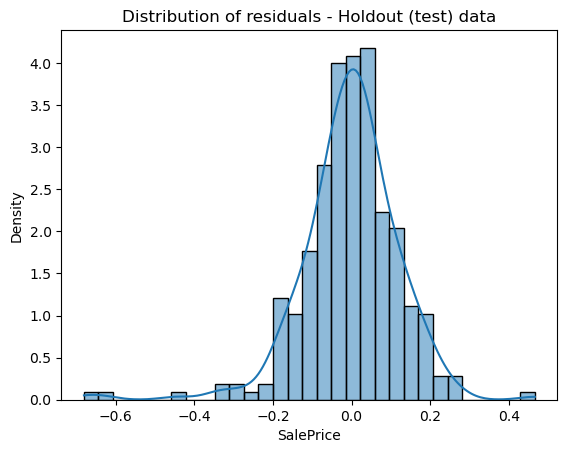

In [44]:
y_hat = lr.predict(test_X)
test_residuals = test_Y - y_hat

sns.histplot(test_residuals, stat = 'density', kde = True)
plt.title("Distribution of residuals - Holdout (test) data")

Text(0.5, 1.0, 'Residuals (x-axis) vs fitted values (y-axis) - Holdout (test) data')

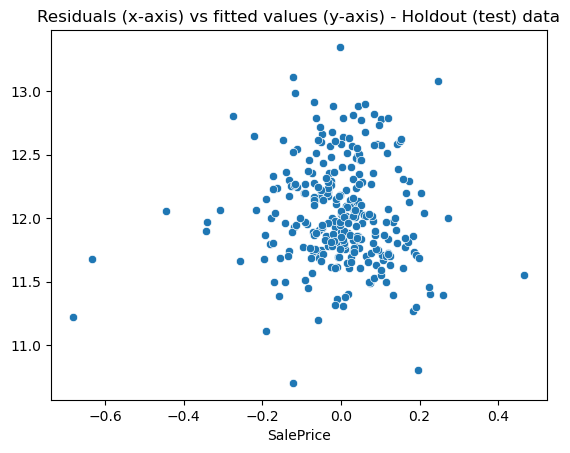

In [45]:
sns.scatterplot(x = test_residuals, y = y_hat)
plt.title("Residuals (x-axis) vs fitted values (y-axis) - Holdout (test) data")

Text(0.5, 1.0, 'Quantile-Quantile Plot - Holdout (test) data')

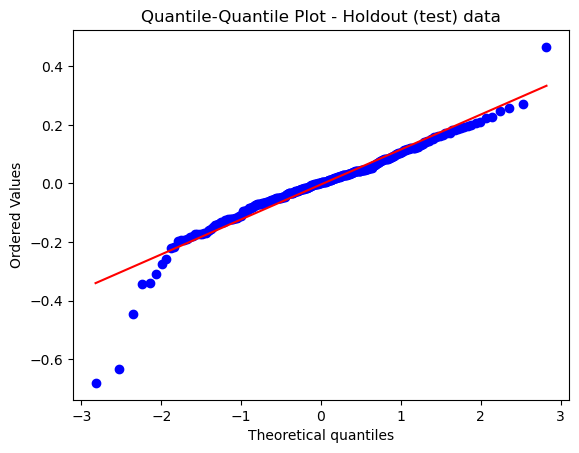

In [46]:
stats.probplot(test_residuals, dist="norm", plot=plt)
plt.title("Quantile-Quantile Plot - Holdout (test) data")

In [47]:
estimates = pd.DataFrame({'Regressor': lr.feature_names_in_, 'Coefficient_lr': lr.coef_,
                          'Coefficient_lasso': lr_lasso.best_estimator_.coef_})
estimates.head(60)

,Regressor,Coefficient_lr,Coefficient_lasso
0,HeatingQC,0.017884,0.017637
1,OverallQual,0.068103,0.066998
2,KitchenQual,0.025918,0.026005
3,ExterQual,0.005689,0.004908
4,BsmtQual,0.028191,0.025659
5,Age,0.029259,0.004583
6,GrLivArea,0.185730,0.159655
7,BedroomAbvGr,-0.014992,-0.012976
8,TotalBsmtSF,0.052964,0.051205
9,FireplaceQu,0.000676,0.001207


## Submission

In [48]:
lr.fit(X, Y)

predictions = np.exp(lr.predict(df_test.drop(['SalePrice', 'Id'], axis = 1)))

submission = pd.DataFrame({'Id': df_test['Id'], 'SalePrice': predictions})

submission.to_csv("submission.csv", index = False)